# Analysis of the SDW phase on the triangular lattice

## Header

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from scipy.constants import pi
from scipy.interpolate import RectBivariateSpline, griddata

from numpy import linalg
from numba import jit

import os
import ast

import pandas as pd

import matplotlib as mpl
plt.rcParams['figure.figsize'] = [6, 4]
mpl.rcParams['figure.dpi'] = 100

## Data Import

Importing data to pandas dataframe

In [2]:
files = [x[0] for x in os.walk("./data/")][1::]

df = pd.DataFrame()
count = 0
for file in files:
    data = pd.read_json(file+'/params.json','index').transpose()
    data["key"] = file
    data["len"] = len( ( data['system_sizes'].to_list())[0] )
    df = df.append(data)
    count += 1

/tmp/ipykernel_10247/2075714840.py:6: FutureWarning: Starting with pandas version 2.0 all arguments of read_json except for the argument 'path_or_buf' will be keyword-only.
  data = pd.read_json(file+'/params.json','index').transpose()
/tmp/ipykernel_10247/2075714840.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)
/tmp/ipykernel_10247/2075714840.py:6: FutureWarning: Starting with pandas version 2.0 all arguments of read_json except for the argument 'path_or_buf' will be keyword-only.
  data = pd.read_json(file+'/params.json','index').transpose()
/tmp/ipykernel_10247/2075714840.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)


In [3]:
df.set_index('key')

,texture,system_sizes,t,m,len
key,,,,,
./data/1607536269,skx,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...",-1,5,61
./data/1607551721,sdw,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...",-1,5,61


In [4]:
stamp='1607551721'
outdir = './data/'+stamp

In [5]:
qs = np.load(outdir+"/qs.npy")
ns = np.load(outdir+"/ns.npy")

In [6]:
n_q = len(qs)

spec = []
for i in range(n_q):
    spec.append( np.load(outdir+"/spec_"+str(i).zfill(4)+".npy") ) 
    
spec = np.array(spec)

/tmp/ipykernel_10247/790488301.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spec = np.array(spec)


In [7]:
X = []
Y = []
for i in range(n_q):
    #for e in np.linspace(0,1,1000):
    for e in spec[i]:
        X.append( qs[i])
        Y.append( e)

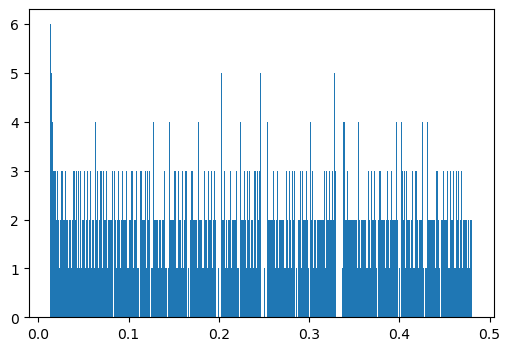

In [8]:
plt.hist(qs,bins=n_q//2);
plt.show()

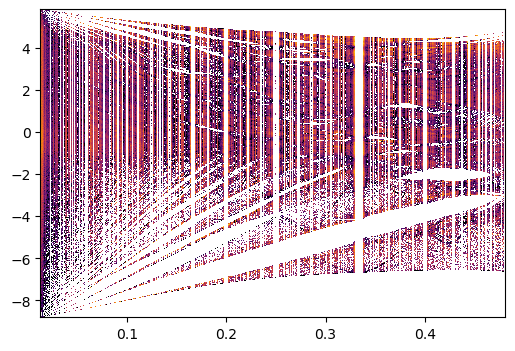

In [9]:
plt.hist2d(X,Y,bins=n_q,cmap='inferno',norm=colors.LogNorm())
plt.show()

In [10]:
Emins = np.zeros(n_q)
Emaxs  = np.zeros(n_q)
for i in range(n_q):
    Emins[i] = np.amin(spec[i])
    Emaxs[i] = np.amax(spec[i])
    
Emin = np.amin(Emins)
Emax = np.amax(Emaxs)

In [11]:
@jit(nopython=True)
def fermi(E,mu,kbT):
    return 1.0 / ( np.exp( (E-mu) / kbT) + 1)

@jit(nopython=True)
def dfermi(E,mu,kbT):
    return 1.0/(2*kbT + 2*kbT*np.cosh((E - mu)/kbT))

In [12]:
@jit(nopython=True)
def dos(mu, kbT, spec):
       
    dens = 0.0 
    
    for level in spec:
        dens += dfermi(level,mu,kbT)
        
    return dens / ( len(spec) / 2.0)

@jit(nopython=True)
def ids(mu, spec):
       
    dens = 0.0 
    
    for level in spec:
        if level < mu:
            dens += 1
        
    return dens / ( len(spec) / 2.0)

## Calculate DOS and IDS

In [13]:
nmu = 500
kbT = 0.02
mus = np.linspace(Emin,Emax,nmu)

Q   = np.zeros(nmu*n_q)
DQ   = np.zeros(nmu*n_q)
DOS = np.zeros(nmu*n_q)
IDS = np.zeros(nmu*n_q)
MU  = np.zeros(nmu*n_q)


k = 0 
for i in range(nmu):
    for j in range(n_q):
        
        Q[k]   = qs[j]
        if j+1 < n_q:
            DQ[k]  = qs[j+1] - qs[j]
        IDS[k] = ids(mus[i], spec[j]) 
        DOS[k] = dos(mus[i], kbT, spec[j]) 
        MU[k]  = mus[i]
        
        k += 1

## Interpolation

In [14]:
interpolation_order = 1
fids = RectBivariateSpline(mus, qs, np.reshape(IDS, (nmu,n_q)), kx=interpolation_order, ky=interpolation_order) 
fdos = RectBivariateSpline(mus, qs, np.reshape(DOS, (nmu,n_q)), kx=interpolation_order, ky=interpolation_order) 
fqdens = RectBivariateSpline(mus, qs, np.reshape(DQ, (nmu,n_q)), kx=interpolation_order, ky=interpolation_order) 

In [15]:
n_qi  = 500
n_mui = 500

qi = np.linspace(np.amin(qs),np.amax(qs),n_qi)

mui = np.linspace(Emin,Emax,n_mui)

Qi, MUi = np.meshgrid(qi,mui,indexing='ij')
DOSi = np.zeros( (n_qi, n_mui))
IDSi = np.zeros( (n_qi, n_mui))
QDENSi = np.zeros( (n_qi, n_mui))
for i in range(n_qi):
    for j in range(n_mui):
            
        DOSi[i,j] = np.abs(fdos( MUi[i,j], Qi[i,j]))
        IDSi[i,j] = np.abs(fids( MUi[i,j], Qi[i,j]))
        QDENSi[i,j] = np.abs(fqdens( MUi[i,j], Qi[i,j]))

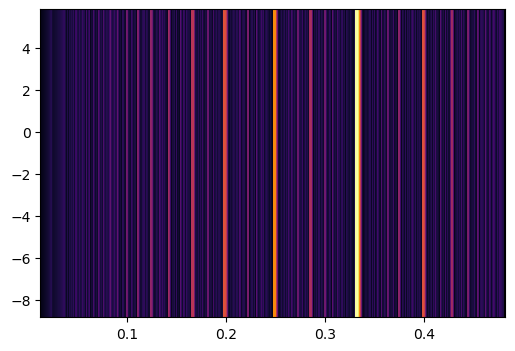

In [16]:
plt.pcolormesh(Qi,MUi,QDENSi, cmap='inferno')

In [17]:
mindens = np.amax(QDENSi)
maxdens = np.amax(QDENSi)

## Plot DOS

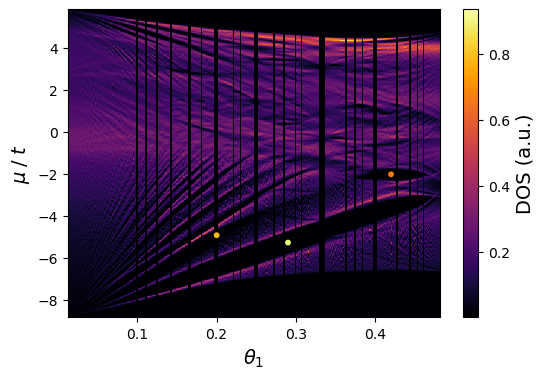

In [18]:
fs = 14
cbarfs = 12

DOSi2 = np.copy(DOSi)
threshold = QDENSi > 0.25*maxdens
DOSi2[threshold] = 0.0

colmin = np.amin(DOSi2[DOSi2>0.001])
colmax = np.amax(DOSi2[DOSi2>0.001])

plt.pcolormesh(Qi,MUi,DOSi2, cmap='inferno',vmin=colmin, vmax=colmax);
ax = plt.gca()
ax.set_xlabel(r"$\theta_1$",fontsize=fs)
ax.set_ylabel(r"$\mu \; / \; t$",fontsize=fs)

cbar = plt.colorbar()
cbar.set_label(label=r'DOS (a.u.)', size=fs)

#attaching gap labels
gaps = np.array( [ [0.29, -5.25],[0.2, -4.9], [0.42, -2] ] )
gaps_class = [0,1,2]
plt.scatter(gaps[:,0],gaps[:,1],c=gaps_class, cmap='Wistia',s=10)


plt.savefig("vortex_spectrum_masked.png", dpi=1000)
plt.show()

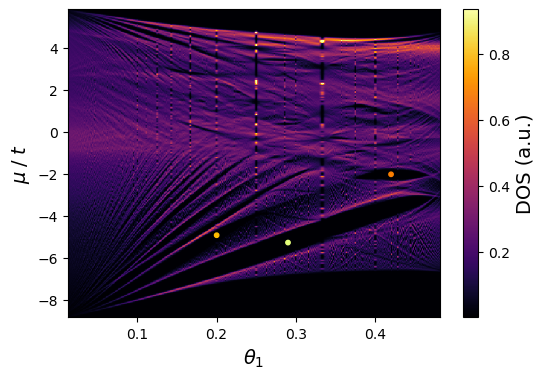

In [19]:
fs = 14
cbarfs = 12


colmin = np.amin(DOSi2[DOSi2>0.001])
colmax = np.amax(DOSi2[DOSi2>0.001])

plt.pcolormesh(Qi,MUi,DOSi, cmap='inferno',vmin=colmin, vmax=colmax);
ax = plt.gca()
ax.set_xlabel(r"$\theta_1$",fontsize=fs)
ax.set_ylabel(r"$\mu \; / \; t$",fontsize=fs)

cbar = plt.colorbar()
cbar.set_label(label=r'DOS (a.u.)', size=fs)

#attaching gap labels
gaps = np.array( [ [0.29, -5.25],[0.2, -4.9], [0.42, -2] ] )
gaps_class = [0,1,2]
plt.scatter(gaps[:,0],gaps[:,1],c=gaps_class, cmap='Wistia',s=10)


plt.savefig("vortex_spectrum.png", dpi=1000)
plt.show()

In [20]:
gaps_q = gaps[:,0]
gaps_mu = gaps[:,1]
gaps_ids = np.array( [ fids( gaps_mu[i], gaps_q[i]) for i in range(len(gaps)) ] )

/tmp/ipykernel_10247/1885173615.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(Qi, IDSi, MUi, cmap='RdBu',vmin=-8,vmax=0)


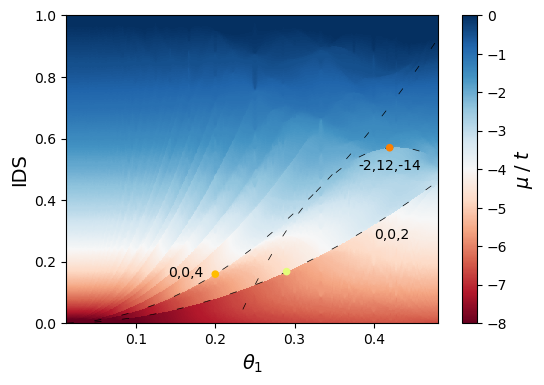

In [27]:
plt.pcolormesh(Qi, IDSi, MUi, cmap='RdBu',vmin=-8,vmax=0)
ax = plt.gca()
ax.set_xlabel(r"$\theta_1$",fontsize=fs)
ax.set_ylabel(r"IDS",fontsize=fs)
ax.set_ylim(0,1)
cbar = plt.colorbar()
cbar.set_label(label=r"$\mu \; / \; t$", size=fs)

no = 12
alp = -(no+2)
bet = no
gam = (2-alp-2*bet)/4.0

tups = [  [0,0,2], [0,0,4], [gam,bet,alp]]#, [1,2,-2]]

for tup in tups:
    n , k, l = tup
    spec2 = ( n + k*qs + l*qs**2  ) 
    plt.plot(qs,spec2, color='black', linewidth=.5, linestyle='--', dashes=(10, 30))

plt.scatter(gaps_q, gaps_ids,c=gaps_class, cmap='Wistia', s=20, zorder=10)

ax.annotate('0,0,2', xy=(0.4, 0.275), rotation=0, fontsize=10)
ax.annotate('0,0,4', xy=(0.14, 0.15), rotation=0, fontsize=10)
ax.annotate('-2,12,-14', xy=(0.38, 0.5), rotation=0, fontsize=10)

#plt.title(r"3Q-SkX ($N_x= N_y = 70$)",fontsize=10)
plt.savefig("vortex_ktheory.png", dpi=1000)
plt.show()

In [26]:
alp

-14